GRIP @ The Sparks Foundation
# Task-7 Stock Market Prediction using Numerical and Textual Analysis
In this task I tried to create a hybrid model for stock performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.

(Used Stack LSTM)

Date : 16-11-2022

Datasets used

Historical stock prices :https://finance.yahoo.com/
Textual news headlines : https://bit.ly/36fFPI6 

In [ ]:
#importing libraries 
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
nltk.download('vader_lexicon')

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Step 1 : Importing the Numerical dataset and performing Exploratory Analysis**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# reading the datasets into pandas

stock_price = pd.read_csv('/content/drive/MyDrive/TheSparkFoundation/AAPL.csv')
stock_headlines = pd.read_csv('/content/drive/MyDrive/TheSparkFoundation/india-news-headlines.csv')

In [ ]:
# displaying stock price dataset
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-03,150.389999,151.970001,149.820007,151.490005,150.645859,54511500
1,2021-11-04,151.580002,152.429993,150.639999,150.960007,150.118805,60394600
2,2021-11-05,151.889999,152.199997,150.059998,151.279999,150.656570,65463900
3,2021-11-08,151.410004,151.570007,150.160004,150.440002,149.820038,55020900
4,2021-11-09,150.199997,151.429993,150.059998,150.809998,150.188492,56787900


**Step 2: Feature Engineering**

In [ ]:
# displaying number of records in both stock_price and stock_headlines datasets
len(stock_price), len(stock_headlines)

(253, 3650970)

In [ ]:
# checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool, publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

**Step 2.1 : Stock Price Data**

In [ ]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2021-11-03,151.490005,150.389999,151.970001,149.820007,54511500
2021-11-04,150.960007,151.580002,152.429993,150.639999,60394600
2021-11-05,151.279999,151.889999,152.199997,150.059998,65463900
2021-11-08,150.440002,151.410004,151.570007,150.160004,55020900
2021-11-09,150.809998,150.199997,151.429993,150.059998,56787900
...,...,...,...,...,...
2022-10-28,155.740005,148.199997,157.500000,147.820007,164762400
2022-10-31,153.339996,153.160004,154.240005,151.919998,97943200
2022-11-01,150.649994,155.080002,155.449997,149.130005,80379300


**Step : 2.2 Stock News Headlines Data**


In [ ]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


**Step 2.3 Combined Stock Data**

In [ ]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2021-11-03,151.490005,150.389999,151.970001,149.820007,54511500.0,"Arrangements made for counting of votes today,..."
2021-11-04,150.960007,151.580002,152.429993,150.639999,60394600.0,Horoscope Today; 4 November 2021: Check astrol...
2021-11-05,151.279999,151.889999,152.199997,150.059998,65463900.0,Horoscope Today; 5 November 2021: Check astrol...
2021-11-08,150.440002,151.410004,151.570007,150.160004,55020900.0,GMDA sets Nov 15 deadline to complete post-mon...
2021-11-09,150.809998,150.199997,151.429993,150.059998,56787900.0,Measurement of 150ha for eastern ring road beg...
...,...,...,...,...,...,...
2022-03-25,174.720001,173.880005,175.279999,172.750000,80546200.0,Speeding up; shortcuts and tackling unruly cus...
2022-03-28,175.600006,172.169998,175.729996,172.000000,90371900.0,As fashion becomes democratic; demand for styl...
2022-03-29,178.960007,176.690002,179.009995,176.339996,100589400.0,Bobby Deol: Like my dad; I hope to be working ...
2022-03-30,177.770004,178.550003,179.610001,176.699997,92633200.0,"I will not give in to trends: Dossmode,The tim..."


**Step 2.4 Calculating Sentiment Scores**

In [ ]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2021-11-03,151.490005,150.389999,151.970001,149.820007,54511500.0,"Arrangements made for counting of votes today,...",,,,
2021-11-04,150.960007,151.580002,152.429993,150.639999,60394600.0,Horoscope Today; 4 November 2021: Check astrol...,,,,
2021-11-05,151.279999,151.889999,152.199997,150.059998,65463900.0,Horoscope Today; 5 November 2021: Check astrol...,,,,
2021-11-08,150.440002,151.410004,151.570007,150.160004,55020900.0,GMDA sets Nov 15 deadline to complete post-mon...,,,,
2021-11-09,150.809998,150.199997,151.429993,150.059998,56787900.0,Measurement of 150ha for eastern ring road beg...,,,,


In [ ]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2021-11-03,151.490005,150.389999,151.970001,149.820007,54511500.0,"Arrangements made for counting of votes today,...",-0.9990,0.122,0.779,0.099
2021-11-04,150.960007,151.580002,152.429993,150.639999,60394600.0,Horoscope Today; 4 November 2021: Check astrol...,-0.9983,0.115,0.784,0.101
2021-11-05,151.279999,151.889999,152.199997,150.059998,65463900.0,Horoscope Today; 5 November 2021: Check astrol...,-0.9495,0.103,0.798,0.099
2021-11-08,150.440002,151.410004,151.570007,150.160004,55020900.0,GMDA sets Nov 15 deadline to complete post-mon...,-0.9994,0.115,0.799,0.086
2021-11-09,150.809998,150.199997,151.429993,150.059998,56787900.0,Measurement of 150ha for eastern ring road beg...,-0.9998,0.118,0.820,0.062


**Step 3 : Finalising Stock Data and writing to Disk**

In [ ]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2021-11-03,151.490005,-0.9990,0.122,0.779,0.099,150.389999,151.970001,149.820007,54511500.0
2021-11-04,150.960007,-0.9983,0.115,0.784,0.101,151.580002,152.429993,150.639999,60394600.0
2021-11-05,151.279999,-0.9495,0.103,0.798,0.099,151.889999,152.199997,150.059998,65463900.0
2021-11-08,150.440002,-0.9994,0.115,0.799,0.086,151.410004,151.570007,150.160004,55020900.0
2021-11-09,150.809998,-0.9998,0.118,0.820,0.062,150.199997,151.429993,150.059998,56787900.0


In [ ]:
# writing the prepared stock_data to disk
stock_data.to_csv('/content/drive/MyDrive/TheSparkFoundation/stock_datafinal.csv')

**Step 4 : Reading Stock Data**

In [ ]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('/content/drive/MyDrive/TheSparkFoundation/stock_datafinal.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2021-11-03,151.490005,-0.9990,0.122,0.779,0.099,150.389999,151.970001,149.820007,54511500.0
2021-11-04,150.960007,-0.9983,0.115,0.784,0.101,151.580002,152.429993,150.639999,60394600.0
2021-11-05,151.279999,-0.9495,0.103,0.798,0.099,151.889999,152.199997,150.059998,65463900.0
2021-11-08,150.440002,-0.9994,0.115,0.799,0.086,151.410004,151.570007,150.160004,55020900.0
2021-11-09,150.809998,-0.9998,0.118,0.820,0.062,150.199997,151.429993,150.059998,56787900.0


**Step 5 : Feature Engineering of Stock Data**

In [ ]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(103, 9)

In [ ]:
# checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [ ]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,1.030000e+02
mean,166.841651,-0.979871,0.131893,0.790845,0.077272,166.554466,168.759127,164.658640,9.620241e+07
std,8.866768,0.196669,0.016897,0.020376,0.010473,8.991016,8.881417,8.847298,2.852666e+07
min,147.869995,-0.999900,0.091000,0.743000,0.053000,148.429993,149.429993,147.479996,4.100000e+07
25%,160.584999,-0.999900,0.118500,0.776000,0.069500,160.110001,162.865005,158.050003,7.710550e+07
50%,168.639999,-0.999800,0.134000,0.789000,0.077000,167.990005,170.350006,165.940002,9.142050e+07
75%,174.585000,-0.999650,0.142500,0.804500,0.084000,173.459999,175.604996,171.714996,1.085037e+08
max,182.009995,0.996100,0.168000,0.848000,0.107000,182.630005,182.940002,179.119995,1.954327e+08


In [ ]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 2021-11-03 to 2022-03-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     103 non-null    float64
 1   compound  103 non-null    float64
 2   negative  103 non-null    float64
 3   neutral   103 non-null    float64
 4   positive  103 non-null    float64
 5   Open      103 non-null    float64
 6   High      103 non-null    float64
 7   Low       103 non-null    float64
 8   Volume    103 non-null    float64
dtypes: float64(9)
memory usage: 8.0+ KB


**Step 6 : EDA of Stock Data**

Text(0, 0.5, 'Close Price ($)')

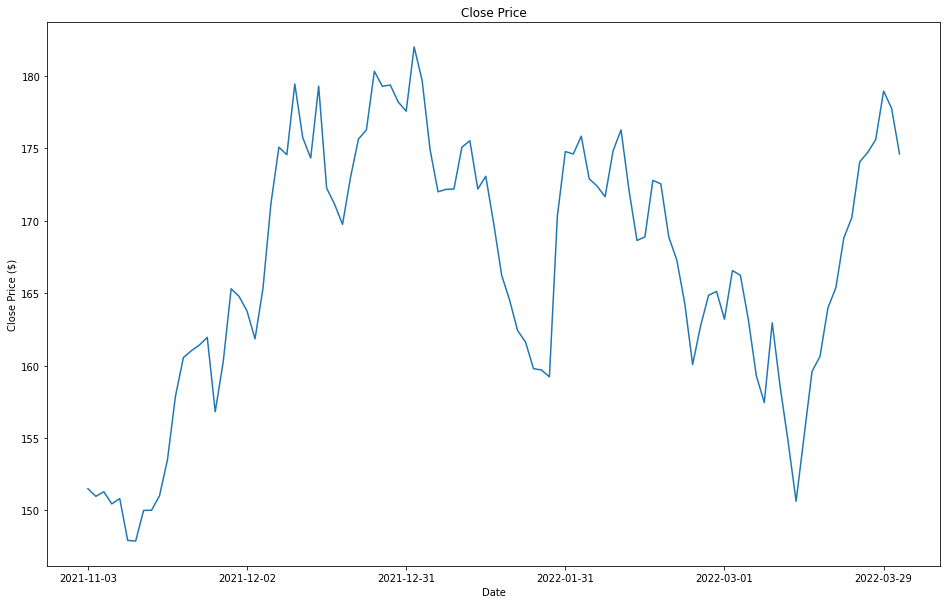

In [ ]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [ ]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2021-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-11,150.110001,-0.992200,0.118571,0.794286,0.087143,150.635716,151.308570,149.467144,5.690941e+07
2021-11-12,149.895715,-0.992329,0.124714,0.789143,0.086143,150.355715,151.084283,149.132856,5.823691e+07
2021-11-15,149.758571,-0.992557,0.129143,0.787143,0.083857,150.182857,151.005713,148.959998,5.806951e+07


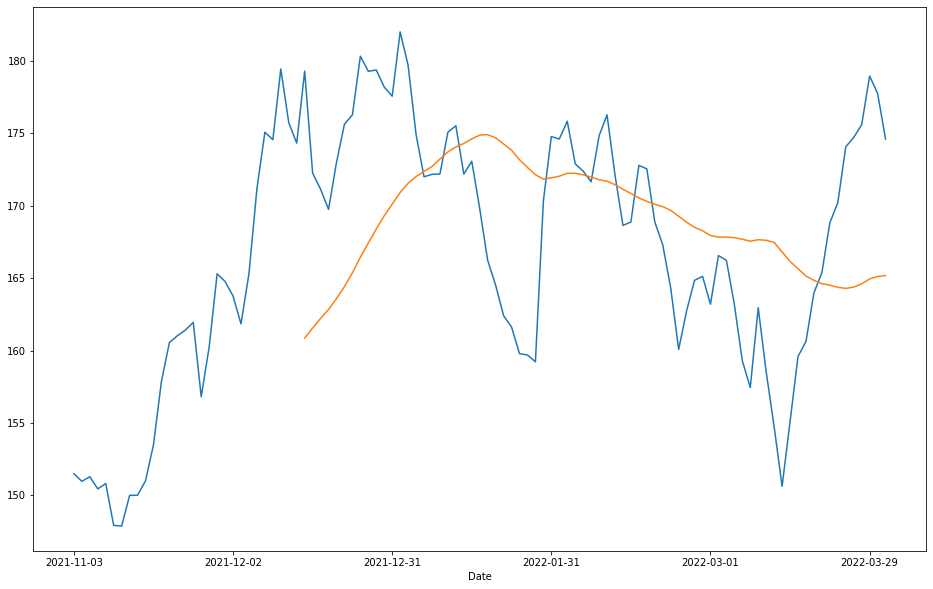

In [ ]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [ ]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2021-11-03,151.490005,-0.9990,0.122,0.779,0.099,150.389999,151.970001,149.820007,54511500.0
2021-11-04,150.960007,-0.9983,0.115,0.784,0.101,151.580002,152.429993,150.639999,60394600.0
2021-11-05,151.279999,-0.9495,0.103,0.798,0.099,151.889999,152.199997,150.059998,65463900.0
2021-11-08,150.440002,-0.9994,0.115,0.799,0.086,151.410004,151.570007,150.160004,55020900.0
2021-11-09,150.809998,-0.9998,0.118,0.820,0.062,150.199997,151.429993,150.059998,56787900.0
...,...,...,...,...,...,...,...,...,...
2022-03-25,174.720001,-0.9999,0.160,0.774,0.066,173.880005,175.279999,172.750000,80546200.0
2022-03-28,175.600006,-0.9999,0.151,0.763,0.086,172.169998,175.729996,172.000000,90371900.0
2022-03-29,178.960007,-0.9998,0.131,0.789,0.080,176.690002,179.009995,176.339996,100589400.0


**Step 7 : Data Preparation for Modelling**

In [ ]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 81
Number of records in Test Data: 22


In [ ]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2021-11-04    150.960007
2021-11-05    151.279999
2021-11-08    150.440002
2021-11-09    150.809998
2021-11-10    147.919998
                 ...    
2022-03-25    174.720001
2022-03-28    175.600006
2022-03-29    178.960007
2022-03-30    177.770004
2022-03-31    174.610001
Name: Close, Length: 102, dtype: float64

In [ ]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2021-11-04,150.960007,151.279999,-0.9983,-0.9495,60394600.0,151.580002,152.429993,150.639999
2021-11-05,151.279999,150.440002,-0.9495,-0.9994,65463900.0,151.889999,152.199997,150.059998
2021-11-08,150.440002,150.809998,-0.9994,-0.9998,55020900.0,151.410004,151.570007,150.160004
2021-11-09,150.809998,147.919998,-0.9998,-0.9995,56787900.0,150.199997,151.429993,150.059998
2021-11-10,147.919998,147.869995,-0.9995,-0.9999,65187100.0,150.020004,150.130005,147.850006
2021-11-11,147.869995,149.990005,-0.9999,-0.9999,41000000.0,148.960007,149.429993,147.679993
2021-11-12,149.990005,150.000000,-0.9999,-0.9999,63804000.0,148.429993,150.399994,147.479996
2021-11-15,150.000000,151.000000,-0.9999,-0.9999,59222800.0,150.369995,151.880005,149.429993
2021-11-16,151.000000,153.490005,-0.9999,-0.9999,59256200.0,149.940002,151.490005,149.339996


**Step 8 Setting the Target Variable and the Feature Dataset**


In [ ]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2021-11-04    151.279999
2021-11-05    150.440002
2021-11-08    150.809998
2021-11-09    147.919998
2021-11-10    147.869995
                 ...    
2022-03-24    174.720001
2022-03-25    175.600006
2022-03-28    178.960007
2022-03-29    177.770004
2022-03-30    174.610001
Name: close_price_shifted, Length: 101, dtype: float64

In [ ]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2021-11-04,150.960007,-0.9983,-0.9495,60394600.0,151.580002,152.429993,150.639999
2021-11-05,151.279999,-0.9495,-0.9994,65463900.0,151.889999,152.199997,150.059998
2021-11-08,150.440002,-0.9994,-0.9998,55020900.0,151.410004,151.570007,150.160004
2021-11-09,150.809998,-0.9998,-0.9995,56787900.0,150.199997,151.429993,150.059998
2021-11-10,147.919998,-0.9995,-0.9999,65187100.0,150.020004,150.130005,147.850006
...,...,...,...,...,...,...,...
2022-03-24,174.070007,-0.9999,-0.9999,90131400.0,171.059998,174.139999,170.210007
2022-03-25,174.720001,-0.9999,-0.9999,80546200.0,173.880005,175.279999,172.750000
2022-03-28,175.600006,-0.9999,-0.9998,90371900.0,172.169998,175.729996,172.000000


**8.1 Scaling the Target Variable and the Feature Dataset**

In [ ]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-8.18979965e-01, -9.98396794e-01, -9.49498998e-01,
         -7.48827807e-01, -8.15789012e-01, -8.20949019e-01,
         -8.00252649e-01],
        [-8.00234095e-01, -9.49498998e-01, -9.99498998e-01,
         -6.83177203e-01, -7.97660539e-01, -8.34676022e-01,
         -8.36915166e-01],
        [-8.49443058e-01, -9.99498998e-01, -9.99899800e-01,
         -8.18420581e-01, -8.25730412e-01, -8.72276131e-01,
         -8.30593674e-01],
        [-8.27767838e-01, -9.99899800e-01, -9.99599198e-01,
         -7.95536826e-01, -8.96491030e-01, -8.80632679e-01,
         -8.36915166e-01],
        [-9.97070709e-01, -9.99599198e-01, -1.00000000e+00,
         -6.86761936e-01, -9.07016933e-01, -9.58220721e-01,
         -9.76611251e-01],
        [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -9.69005040e-01, -1.00000000e+00,
         -9.87357964e-01],
        [-8.75804921e-01, -1.00000000e+00, -1.00000000e+00,
         -7.04673945e-01, -1.00000000e+00, -9.42106790e-01

**Step 8.2 Dividing the dataset into Training and Test**

In [ ]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (81, 7) and y: (81, 1)
Number of rows and columns in the Test set X: (19, 7) and y: (19, 1)


**Step 8.3 Reshaping the Feature Dataset**

In [ ]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (81, 7, 1)
Shape of Test set X: (19, 7, 1)


**Step 9 Stock Data Modelling**

In [ ]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))

model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [ ]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.35, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
7/7 [==============================] - 7s 271ms/step - loss: 0.3321 - val_loss: 0.1094
Epoch 2/50
7/7 [==============================] - 0s 23ms/step - loss: 0.2225 - val_loss: 0.0930
Epoch 3/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0596 - val_loss: 0.1777
Epoch 4/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0888 - val_loss: 0.0532
Epoch 5/50
7/7 [==============================] - 0s 24ms/step - loss: 0.0493 - val_loss: 0.0583
Epoch 6/50
7/7 [==============================] - 0s 26ms/step - loss: 0.0468 - val_loss: 0.0576
Epoch 7/50
7/7 [==============================] - 0s 24ms/step - loss: 0.0432 - val_loss: 0.0729
Epoch 8/50
7/7 [==============================] - 0s 23ms/step - loss: 0.0412 - val_loss: 0.0553
Epoch 9/50
7/7 [==============================] - 0s 23ms/step - loss: 0.0453 - val_loss: 0.0533
Epoch 10/50
7/7 [==============================] - 0s 24ms/step - loss: 0.0420 - val_loss: 0.0645
Epoch 11/50
7/7 [===========

In [ ]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('/content/drive/MyDrive/TheSparkFoundation/model.h5')
print('Model is saved to the disk')

Model is saved to the disk


**Step 10: Predictions**

In [ ]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

1/1 [==============================] - 1s 1s/step
Predictions:


array([[163.35771],
       [160.31815],
       [159.57672],
       [163.0254 ],
       [159.4726 ]], dtype=float32)

**Step 11: Model Evaluation**

In [ ]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

19/19 [==============================] - 0s 3ms/step - loss: 0.0323
Train Loss = 0.0342
Test Loss = 0.0323


In [ ]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 165.6279


In [ ]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 165.6279


In [ ]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

**Step 12 : Plotting the Predictions against unseen data**

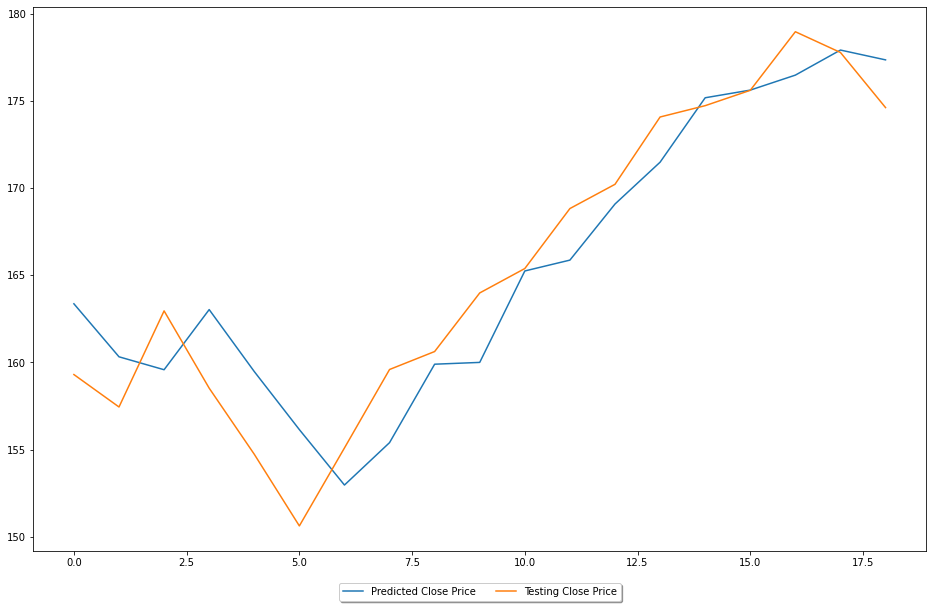

In [ ]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

**Thank You**